In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from utils.datasets.foscal.patient import FOSCALPatient
from utils.preprocessing.numpy import get_idxs_of_annotated_slices
from metrics import compute_segmentation_metrics

# Load the data

In [77]:
patients = []
patients_label = []
dset_dir = "/data/Datasets/stroke/ISBI_FOSCAL/"
patient_dirs = glob(os.path.join(dset_dir, "*"))
for patient_dir in patient_dirs:
    patient = FOSCALPatient(patient_dir)
    patients.append(patient)
    patients_label.append(patient_dir.split('/')[5][:])

In [78]:
modalities = ["ADC", "DWI"]
masks_daniel = patients[1].get_mask(modalities=modalities, radiologist="Daniel")
masks_andres = patients[1].get_mask(modalities=modalities, radiologist="Andres")

In [79]:
idxs_with_annotations = get_idxs_of_annotated_slices(masks_daniel["ADC"])
masks_daniel["ADC"] = masks_daniel["ADC"][..., idxs_with_annotations]

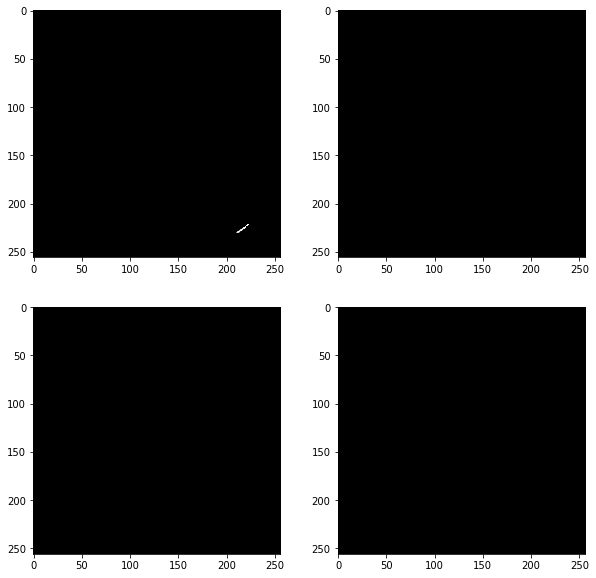

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(masks_daniel["ADC"][..., 0], cmap="gray")
axs[0, 1].imshow(masks_daniel["DWI"][..., 0], cmap="gray")
axs[1, 0].imshow(masks_andres["ADC"][..., 0], cmap="gray")
axs[1, 1].imshow(masks_andres["DWI"][..., 0], cmap="gray")

# Visualize some cases

In [81]:
modalities = ["ADC", "DWI"]
normalization = "min_max"
data = patients[0].get_data(modalities=modalities, normalization=normalization)
masks = patients[0].get_mask(modalities=modalities)

In [82]:
compute_segmentation_metrics(masks["DWI"], masks["ADC"])

{'sens': 0.0,
 'spec': 0.9998570315583333,
 'ppv': 0.0,
 'npv': 0.999799739893307,
 'dsc': 0.0,
 'avd': 0.33389544688026984,
 'hd': 19.339079605813716}

# Agreement between radiologists using ADC masks

--------------------------------
ACV-033
0 1727579
1727826 174
1727753 247
1728000
-0.00011816848811488544
--------------------------------
--------------------------------
ACV-044
0 1638335
1638358 42
1638377 23
1638400
-1.8141854828931586e-05
--------------------------------
--------------------------------
ACV-043
1660 1725647
1726295 1705
1725692 2308
1728000
0.8271150224182775
--------------------------------
--------------------------------
ACV-034
295 1701984
1703413 523
1702212 1724
1703936
0.2622248331942775
--------------------------------
--------------------------------
ACV-006
515 1702919
1703247 689
1703093 843
1703936
0.672177877355239
--------------------------------
--------------------------------
ACV-005
235 1694995
1695071 673
1695433 311
1695744
0.47751119925547647
--------------------------------
--------------------------------
ACV-051
125 1572616
1572703 161
1572652 212
1572864
0.6702029127330877
--------------------------------
--------------------------------


([<matplotlib.patches.Wedge at 0x7f8ae4be7490>,
 [Text(0.9910657451172095, 0.47727213291294374, 'Fair [0.2-0.4]'),
  Text(-0.24477311341532162, 1.0724206837565984, 'Moderate [0.4-0.6]'),
  Text(-1.0999999999999892, -1.5448414893833034e-07, 'Near perfect [0.8-1]'),
  Text(-0.47727194733239225, -0.991065834488076, 'No [0-0.1]'),
  Text(0.8600147545539076, -0.6858386267552901, 'Substantial [0.6-0.8]')],
 [Text(0.5405813155184778, 0.2603302543161511, '14%'),
  Text(-0.13351260731744813, 0.5849567365945082, '29%'),
  Text(-0.5999999999999941, -8.426408123908927e-08, '14%'),
  Text(-0.26033015309039576, -0.5405813642662232, '21%'),
  Text(0.46909895702940413, -0.3740937964119763, '21%')])

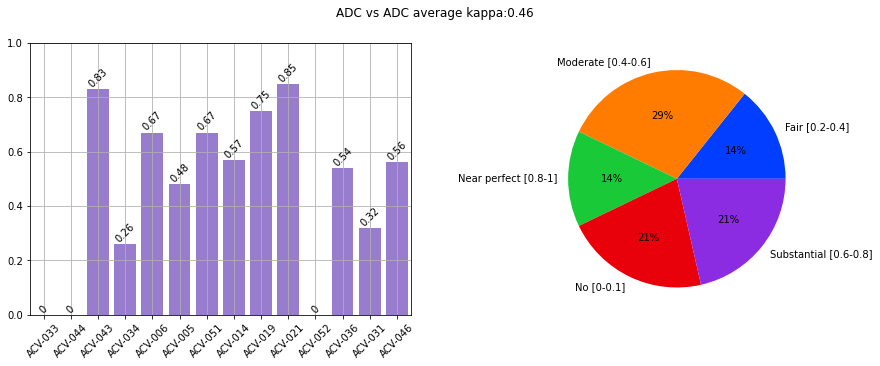

In [90]:
Kappas = []
modality = "ADC"
category = []

for idx_p, patient in enumerate(patients):
    masks_daniel = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Daniel")[modality], axis=2)
    masks_andres = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Andres")[modality], axis=2)

    dims = np.shape(masks_daniel)
    total = dims[0]*dims[1]*dims[2]*dims[3]

    andres_0 = np.sum(masks_andres == 0)
    daniel_0 = np.sum(masks_daniel == 0)
    andres_1 = np.sum(masks_andres == 1)
    daniel_1 = np.sum(masks_daniel == 1)

    andres_daniel_0 = np.sum(np.sum(np.concatenate((masks_andres == 0, masks_daniel == 0), axis=2), axis=2) == 2)
    andres_daniel_1 = np.sum(np.sum(np.concatenate((masks_andres == 1, masks_daniel == 1), axis=2), axis=2) == 2)

    p_0  = (andres_daniel_0 + andres_daniel_1)/total
    si_a = (andres_1/total) * (daniel_1/total)
    no_a = (andres_0/total) * (daniel_0/total)
    p_e  = si_a + no_a
    kappa = (p_0 - p_e)/(1 - p_e)

    Kappas.append(round(kappa, 2))

    if kappa <0.1:
        category.append('No [0-0.1]')
    elif 0.1<=kappa<0.2:
        category.append('Slight [0.1-0.2]')
    elif 0.2<=kappa<0.4:
        category.append('Fair [0.2-0.4]')
    elif 0.4<=kappa<0.6:
        category.append('Moderate [0.4-0.6]')
    elif 0.6<=kappa<0.8:
        category.append('Substantial [0.6-0.8]')
    elif 0.8<=kappa<1:
        category.append('Near perfect [0.8-1]')


    print("--------------------------------")
    print(patients_label[idx_p])
    print(andres_daniel_1, andres_daniel_0)
    print(andres_0, andres_1)
    print(daniel_0, daniel_1)
    print(total)
    print(kappa)
    print("--------------------------------")

print("kappa primedio:",np.mean(Kappas))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("ADC vs ADC average kappa:{}".format(round(np.mean(Kappas), 2)))

g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_label, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

for idx, container in enumerate(g.containers):
    g.bar_label(container,rotation=45)

ax1.grid(0.3)
ax1.set_ylim(0, 1)
ax1.set_xticklabels(patients_label, rotation=45)

data = [np.sum(np.array(category) == i) for i in np.unique(category)]
labels = np.unique(category)
colors = sns.color_palette('bright')
ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')
    
    

# Agreement between radiologists using DWI masks

--------------------------------
272 1727635
1727709 291
1727654 346
1728000
0.8539764257193607
--------------------------------
--------------------------------
0 1638323
1638324 76
1638399 1
1638400
-1.2048527860985651e-06
--------------------------------
--------------------------------
2393 1724617
1725536 2464
1724688 3312
1728000
0.8283203650660431
--------------------------------
--------------------------------
3717 1698472
1699473 4463
1699218 4718
1703936
0.809202093419899
--------------------------------
--------------------------------
694 1701798
1703143 793
1701897 2039
1703936
0.4897710629643125
--------------------------------
--------------------------------
0 1688348
1691728 4016
1692364 3380
1695744
-0.00216932346185476
--------------------------------
--------------------------------
0 1570232
1572294 570
1570802 2062
1572864
-0.0005681501549402575
--------------------------------
--------------------------------
0 1703468
1703764 172
1703640 296
1703936
-0.00012770

([<matplotlib.patches.Wedge at 0x7f8ae4f0fee0>,
 [Text(1.0724207009445805, 0.24477303810986792, 'Moderate [0.4-0.6]'),
  Text(-5.149471629032507e-08, 1.0999999999999988, 'Near perfect [0.8-1]'),
  Text(-0.991065700431763, -0.47727222570321337, 'No [0-0.1]'),
  Text(0.6858389488368114, -0.8600144977024619, 'Substantial [0.6-0.8]')],
 [Text(0.5849567459697711, 0.13351256624174612, '7%'),
  Text(-2.8088027067450036e-08, 0.5999999999999993, '36%'),
  Text(-0.540581291144598, -0.2603303049290255, '29%'),
  Text(0.37409397209280615, -0.4690988169286155, '29%')])

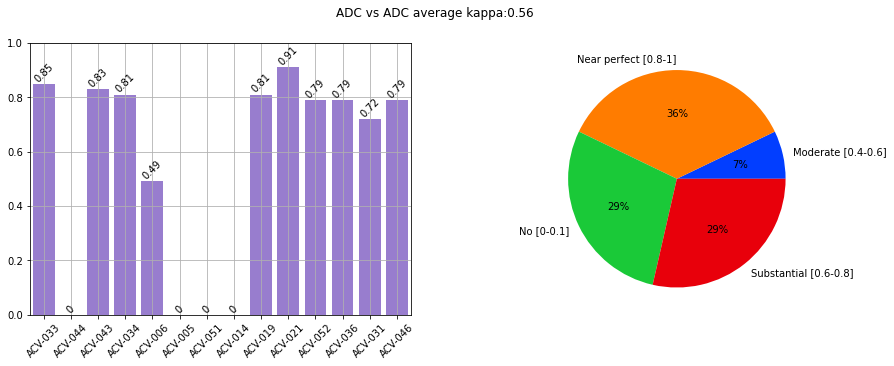

In [91]:
Kappas = []
modality = "DWI"
category = []

for patient in patients:
    masks_daniel = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Daniel")[modality], axis=2)
    masks_andres = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Andres")[modality], axis=2)

    dims = np.shape(masks_daniel)
    total = dims[0]*dims[1]*dims[2]*dims[3]

    andres_0 = np.sum(masks_andres == 0)
    daniel_0 = np.sum(masks_daniel == 0)
    andres_1 = np.sum(masks_andres == 1)
    daniel_1 = np.sum(masks_daniel == 1)

    andres_daniel_0 = np.sum(np.sum(np.concatenate((masks_andres == 0, masks_daniel == 0), axis=2), axis=2) == 2)
    andres_daniel_1 = np.sum(np.sum(np.concatenate((masks_andres == 1, masks_daniel == 1), axis=2), axis=2) == 2)

    p_0  = (andres_daniel_0 + andres_daniel_1)/total
    si_a = (andres_1/total) * (daniel_1/total)
    no_a = (andres_0/total) * (daniel_0/total)
    p_e  = si_a + no_a
    kappa = (p_0 - p_e)/(1 - p_e)

    Kappas.append(round(kappa, 2))

    if kappa <0.1:
        category.append('No [0-0.1]')
    elif 0.1<=kappa<0.2:
        category.append('Slight [0.1-0.2]')
    elif 0.2<=kappa<0.4:
        category.append('Fair [0.2-0.4]')
    elif 0.4<=kappa<0.6:
        category.append('Moderate [0.4-0.6]')
    elif 0.6<=kappa<0.8:
        category.append('Substantial [0.6-0.8]')
    elif 0.8<=kappa<1:
        category.append('Near perfect [0.8-1]')

    print("--------------------------------")
    print(andres_daniel_1, andres_daniel_0)
    print(andres_0, andres_1)
    print(daniel_0, daniel_1)
    print(total)
    print(kappa)
    print("--------------------------------")

print("kappa primedio:",np.mean(Kappas))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("ADC vs ADC average kappa:{}".format(round(np.mean(Kappas), 2)))

g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_label, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

for idx, container in enumerate(g.containers):
    g.bar_label(container,rotation=45)

ax1.grid(0.3)
ax1.set_ylim(0, 1)
ax1.set_xticklabels(patients_label, rotation=45)

data = [np.sum(np.array(category) == i) for i in np.unique(category)]
labels = np.unique(category)
colors = sns.color_palette('bright')
ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')

# Agreement between ADC and DWI masks of the same radiologist

--------------------------------
0 1727462
1727709 291
1727753 247
1728000
-0.00015465397375003892
--------------------------------
--------------------------------
0 1638301
1638324 76
1638377 23
1638400
-2.155389048636569e-05
--------------------------------
--------------------------------
1846 1725074
1725536 2464
1725692 2308
1728000
0.773367201620597
--------------------------------
--------------------------------
1239 1698988
1699473 4463
1702212 1724
1703936
0.39964087506586665
--------------------------------
--------------------------------
354 1702654
1703143 793
1703093 843
1703936
0.43249064929711645
--------------------------------
--------------------------------
266 1691683
1691728 4016
1695433 311
1695744
0.12265024293024256
--------------------------------
--------------------------------
200 1572282
1572294 570
1572652 212
1572864
0.5114129484210784
--------------------------------
--------------------------------
98 1703619
1703764 172
1703693 243
1703936
0.4722267

([<matplotlib.patches.Wedge at 0x7f8ae4d51ac0>,
 [Text(1.0724207009445805, 0.24477303810986792, 'Fair [0.2-0.4]'),
  Text(-0.244773063211686, 1.0724206952152537, 'Moderate [0.4-0.6]'),
  Text(-1.0724206894859265, -0.2447730883135038, 'Near perfect [0.8-1]'),
  Text(-0.47727204012267027, -0.9910657898026469, 'No [0-0.1]'),
  Text(0.4772722025056465, -0.9910657116031254, 'Slight [0.1-0.2]'),
  Text(0.9910658121453628, -0.47727199372753143, 'Substantial [0.6-0.8]')],
 [Text(0.5849567459697711, 0.13351256624174612, '7%'),
  Text(-0.13351257993364687, 0.5849567428446838, '43%'),
  Text(-0.5849567397195962, -0.13351259362554752, '7%'),
  Text(-0.2603302037032747, -0.5405813398923528, '21%'),
  Text(0.2603302922758072, -0.5405812972380684, '7%'),
  Text(0.5405813520792887, -0.2603301783968353, '14%')])

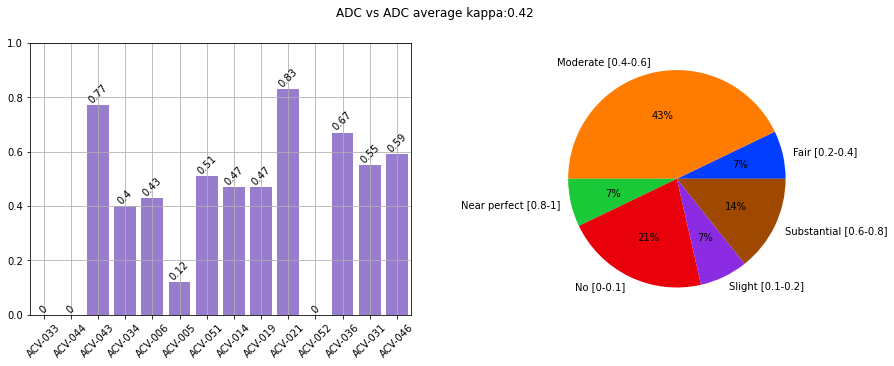

In [92]:
Kappas = []
category = []

for patient in patients:
    masks_daniel = np.expand_dims(patient.get_mask(modalities=['ADC'], radiologist="Daniel")['ADC'], axis=2)
    masks_andres = np.expand_dims(patient.get_mask(modalities=['DWI'], radiologist="Andres")['DWI'], axis=2)

    dims = np.shape(masks_daniel)
    total = dims[0]*dims[1]*dims[2]*dims[3]

    andres_0 = np.sum(masks_andres == 0)
    daniel_0 = np.sum(masks_daniel == 0)
    andres_1 = np.sum(masks_andres == 1)
    daniel_1 = np.sum(masks_daniel == 1)

    andres_daniel_0 = np.sum(np.sum(np.concatenate((masks_andres == 0, masks_daniel == 0), axis=2), axis=2) == 2)
    andres_daniel_1 = np.sum(np.sum(np.concatenate((masks_andres == 1, masks_daniel == 1), axis=2), axis=2) == 2)

    p_0  = (andres_daniel_0 + andres_daniel_1)/total
    si_a = (andres_1/total) * (daniel_1/total)
    no_a = (andres_0/total) * (daniel_0/total)
    p_e  = si_a + no_a
    kappa = (p_0 - p_e)/(1 - p_e)

    Kappas.append(round(kappa, 2))

    if kappa <0.1:
        category.append('No [0-0.1]')
    elif 0.1<=kappa<0.2:
        category.append('Slight [0.1-0.2]')
    elif 0.2<=kappa<0.4:
        category.append('Fair [0.2-0.4]')
    elif 0.4<=kappa<0.6:
        category.append('Moderate [0.4-0.6]')
    elif 0.6<=kappa<0.8:
        category.append('Substantial [0.6-0.8]')
    elif 0.8<=kappa<1:
        category.append('Near perfect [0.8-1]')

    print("--------------------------------")
    print(andres_daniel_1, andres_daniel_0)
    print(andres_0, andres_1)
    print(daniel_0, daniel_1)
    print(total)
    print(kappa)
    print("--------------------------------")

print("kappa primedio:",np.mean(Kappas))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("ADC vs ADC average kappa:{}".format(round(np.mean(Kappas), 2)))

g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_label, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

for idx, container in enumerate(g.containers):
    g.bar_label(container,rotation=45)

ax1.grid(0.3)
ax1.set_ylim(0, 1)
ax1.set_xticklabels(patients_label, rotation=45)

data = [np.sum(np.array(category) == i) for i in np.unique(category)]
labels = np.unique(category)
colors = sns.color_palette('bright')
ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')